Our objective is to perform headline classification based on sarcasm.

In [1]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np, pandas as pd, re, nltk, xgboost as xgb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
df = pd.read_json("C:\\Users\\Anyone\\Desktop\\Sarcasm.json", lines=True)

In [3]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
# Removing 'article_link' column, because we don't need that.

df.drop('article_link',axis=1,inplace=True)

In [5]:
# The dataset is a little imbalanced.

df.is_sarcastic.value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

In [6]:
# We have no missing values.

df.isnull().sum()

is_sarcastic    0
headline        0
dtype: int64

In [7]:
# 116 rows are duplicated.

df.duplicated().sum()

116

In [8]:
# Deleting duplicated rows and resetting the index.

df.drop_duplicates(inplace=True)
df.reset_index(drop=True,inplace=True)

In [9]:
# Here we convert all the text to lowercase, then we use regular expressions to
# remove non-alphabetic characters.
# Then we remove stopwords and apply lemmatization to the headline column.

df.headline = [i.lower() for i in df.headline]
df.headline = [re.sub('[^a-z\s]','',i) for i in df.headline]

stop_words = set(stopwords.words('english'))
df.headline = df.headline.apply(lambda i: ' '.join(nltk.stem.WordNetLemmatizer().lemmatize(i,'v') for i in i.split() if i not in stop_words))

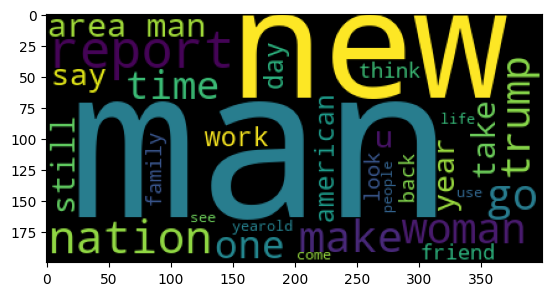

In [10]:
# Plotting a word cloud of most common words in sarcastic headlines.

plt.imshow(WordCloud(max_words=30).generate(' '.join(df.headline[df.is_sarcastic==1])))

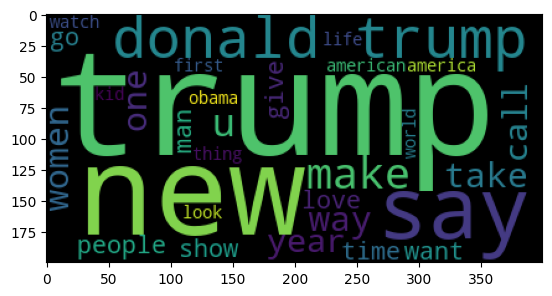

In [11]:
# Doing the same for non-sarcastic headlines.

plt.imshow(WordCloud(max_words=30).generate(' '.join(df.headline[df.is_sarcastic==0])))

In [12]:
# This cell performs tokenization, converts the headline column
# to a sequence of integers and pads those sequences, so that 
# the length of all sentences will be equal.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.headline)
X = tokenizer.texts_to_sequences(df.headline)

max_len = max([len(i) for i in X])

X = pad_sequences(X, maxlen=max_len, padding='post')
y = df.is_sarcastic

In [13]:
# Next we undersample our data to make it balanced.

X_sampled, y_sampled = RandomUnderSampler().fit_resample(X,y)
X_train,X_test,y_train,y_test = train_test_split(X_sampled, y_sampled, test_size=0.2)

In [14]:
# Tuning hyperparameters for random forest classifier.

params_rf = {
    'n_estimators': [10, 20, 40, 60, 80, 100, 120, 130, 150],
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2,3,4,5,6,7,8,9, 10],
    'min_samples_leaf': [1, 2,3,4,5],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()

tune_rf = RandomizedSearchCV(estimator=rf, param_distributions=params_rf, n_iter=50, cv=5)
tune_rf.fit(X_train, y_train)

print("Best hyperparameters: ", tune_rf.best_params_)

Best hyperparameters:  {'n_estimators': 150, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}


In [15]:
# Training and testing the random forest model with the best hyperparameters.

best_rf = RandomForestClassifier(**tune_rf.best_params_)
best_rf.fit(X_train, y_train)
rf_pred = best_rf.predict(X_test)

print(f'\nAccuracy: {round(accuracy_score(y_test,rf_pred)*100,2)}%\n')
print('--'*30)
print(f'\n{confusion_matrix(y_test,rf_pred)}\n')
print('--'*30)
print(f'\n{classification_report(y_test,rf_pred)}')


Accuracy: 61.93%

------------------------------------------------------------

[[2064  587]
 [1477 1293]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.58      0.78      0.67      2651
           1       0.69      0.47      0.56      2770

    accuracy                           0.62      5421
   macro avg       0.64      0.62      0.61      5421
weighted avg       0.64      0.62      0.61      5421



In [16]:
# Here we are tuning hyperparameters for XGboost classifier.

xgb = xgb.XGBClassifier()

params_xgb = {
    'max_depth': [3, 6, 10, 15, 17, 19, 21],
    'learning_rate': [0.003, 0.006, 0.01, 0.1, 0.2, 0.3, 0.4],
    'n_estimators': [100, 250, 400, 500, 600, 750, 800, 850, 900, 950, 1000],
    'gamma': np.arange(0, 1.1, 0.1),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.2, 1.0, 0.1)
}

tune_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=params_xgb, cv=5, n_jobs=-1, n_iter=50)
tune_xgb.fit(X_train, y_train)

print("Best hyperparameters: ", tune_xgb.best_params_)

Best hyperparameters:  {'subsample': 0.7, 'n_estimators': 950, 'max_depth': 21, 'learning_rate': 0.006, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.30000000000000004}


In [20]:
# With our tuned hyperparameters we are going to train and test the XGboost classification model.

best_xgb = XGBClassifier(**tune_xgb.best_params_)
best_xgb.fit(X_train, y_train)
xgb_pred = best_xgb.predict(X_test)

print(f'\nAccuracy: {round(accuracy_score(y_test,xgb_pred)*100,2)}%\n')
print('--'*30)
print(f'\n{confusion_matrix(y_test,xgb_pred)}\n')
print('--'*30)
print(f'\n{classification_report(y_test,xgb_pred)}')


Accuracy: 71.46%

------------------------------------------------------------

[[2016  635]
 [ 912 1858]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.69      0.76      0.72      2651
           1       0.75      0.67      0.71      2770

    accuracy                           0.71      5421
   macro avg       0.72      0.72      0.71      5421
weighted avg       0.72      0.71      0.71      5421

